# Deep Learning Final Project 

## Importing Libraries

In [1]:
import cv2 as cv
import glob
import os
#import timeit
from matplotlib import pyplot as plt
import tensorflow as tf
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from keras.models import load_model
import pickle
from keras.models import Model
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, RepeatVector, merge, concatenate
from keras.initializers import TruncatedNormal
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
%pwd

'/home/jupyter'

## Downloading COCO test data set and taking 40000 for train

In [ ]:
name_of_zip = 'test2017.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
    image_zip = tf.keras.utils.get_file(name_of_zip, cache_subdir=os.path.abspath('.'),origin = 'http://images.cocodataset.org/zips/test2017.zip',extract = True)
    PATH = os.path.dirname(image_zip)+'/test2017/'
else:
    PATH = os.path.abspath('.')+'/test2017/'

## New directory to store pickle files and model

In [5]:
%pwd
%cd Model_Pickle
%pwd

/home/jupyter/Model_Pickle


'/home/jupyter/Model_Pickle'

## Preprocessing steps for images

In [6]:
def imageTransformation(file_path,start,end):

  rgb_array = []
  lab_array_conv = []
  bw_array_resnet = []
  
  i = 0
  for file in sorted(glob.iglob(file_path)): 
      
      if i >= start and i < end:

        #Pure Image
        img = cv.imread(file)

        
        img=cv.cvtColor(img,cv.COLOR_BGR2RGB)
        rgb_array.append(img)
        
        img_lab = rgb2lab(img)
        img_bw = gray2rgb(rgb2gray(img))
        
        
        #Convolution
        resizeconv = cv.resize(img_lab, dsize=(224, 224), interpolation=cv.INTER_CUBIC)
        lab_array_conv.append(resizeconv)

        #ResNet
        resizeresnet = cv.resize(img_bw, dsize=(299, 299), interpolation=cv.INTER_CUBIC)
        bw_array_resnet.append(resizeresnet)
        print("iteration",i)  
      i+=1
    
  return rgb_array ,lab_array_conv,  bw_array_resnet

## Running 5000 batches at a time and saving processed images in pickle

In [ ]:
start=35000
end= 40000
file_path = "/home/jupyter/test2017/*.jpg"
rgb_train, lab_train,bw_train =imageTransformation(file_path,start,end)

In [ ]:
with open("lab_array_train3.pkl", 'wb') as f:
  pickle.dump(lab_train, f)
 
with open("bw_array_train3.pkl", 'wb') as f:
  pickle.dump(bw_train, f)

## Restoring saved processed images from pickle files

In [ ]:
with open('lab_array_train1.pkl', 'rb') as f:
  lab_train = pickle.load(f)

with open('bw_array_train1.pkl', 'rb') as f:
  bw_train = pickle.load(f)

In [ ]:
with open('lab_array_train2.pkl', 'rb') as f:
  lab_train = pickle.load(f)

with open('bw_array_train2.pkl', 'rb') as f:
  bw_train = pickle.load(f)

In [ ]:
with open('lab_array_train3.pkl', 'rb') as f:
  lab_train = pickle.load(f)

#with open('bw_array_train3.pkl', 'rb') as f1:
#  bw_train = pickle.load(f1)

In [ ]:
lab_train.extend(lab_train1)
lab_train.extend(lab_train2)

In [ ]:
bw_train.extend(bw_train1)
bw_train.extend(bw_train2)

## Train and validation split

In [ ]:
bw_train1 = 0
lab_train1 = 0
bw_train2 = 0
lab_train2 = 0
import gc
gc.collect()
trainNum =4500

In [ ]:
lab_val = np.array(lab_train[trainNum:])
bw_val = np.array(bw_train[trainNum:])

In [ ]:
lab_train= np.array(lab_train[:trainNum])
bw_train = np.array(bw_train[:trainNum])

In [ ]:
print(len(lab_val))
print(len(bw_val))
print(len(lab_train))
print(len(bw_train))

## Embedding and pretrained inception ResNetV2 model download

In [ ]:
#Inception
'''
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()
'''

In [ ]:
#Embedding
'''
def inception_embedding(grayscale):
    with inception.graph.as_default():
        embedding = inception.predict(grayscale)
    return embedding
'''    

In [7]:
from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

sess = tf.Session()
graph = tf.get_default_graph()
set_session(sess)
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

def inception_embedding(grayscale):
    global sess
    global graph
    with inception.graph.as_default():
        set_session(sess)
        embedding = inception.predict(grayscale)
    return embedding

Instructions for updating:
If using Keras pass *_constraint arguments to layers.




## Encoder layers

In [8]:
#Baseline Model for CNN - Encoder
#Lab Image
encoder_input = Input(shape=(224, 224, 1,))
encoder_layer1 = Conv2D(64, (3,3), activation='relu', padding='same', strides=2,
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_input)
encoder_layer2 = Conv2D(128, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_layer1)
encoder_layer3 = Conv2D(128, (3,3), activation='relu', padding='same', strides=2,
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_layer2)
encoder_layer4 = Conv2D(256, (3,3), activation='relu', padding='same', 
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_layer3)
encoder_layer5 = Conv2D(256, (3,3), activation='relu', padding='same', strides=2,
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_layer4)
encoder_layer6 = Conv2D(512, (3,3), activation='relu', padding='same', 
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_layer5)
encoder_layer7 = Conv2D(512, (3,3), activation='relu', padding='same', 
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_layer6)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same',
                            bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(encoder_layer7)

encoder_output

<tf.Tensor 'conv2d_211/Relu:0' shape=(?, 28, 28, 256) dtype=float32>

## Fusion layer

In [9]:
embed_input = Input(shape=(1000,))
fusion_vector = RepeatVector(28 * 28)(embed_input)
fusion_vector = Reshape(([28, 28, 1000]))(fusion_vector)
fusion_layer = concatenate([encoder_output, fusion_vector], axis=3)
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same',
                        bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(fusion_layer)

## Decoder layer

In [10]:
#Decoder
decoder_layer1 = Conv2D(128, (3,3), activation='relu', padding='same',
                        bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(fusion_output)
decoder_upsampling1 = UpSampling2D((2, 2))(decoder_layer1)
#decoder_upsampling1 = Conv2DTranspose(64,(2,2),strides=(2,2), activation='relu', padding='same')(decoder_layer1)

decoder_layer2 = Conv2D(64, (3,3), activation='relu', padding='same',
                        bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_upsampling1)
decoder_upsampling2 = UpSampling2D((2, 2))(decoder_layer2)
#decoder_upsampling2 = Conv2DTranspose(32,(2,2),strides=(2,2), activation='relu', padding='same')(decoder_layer2)

decoder_layer3 = Conv2D(32, (3,3), activation='relu', padding='same',
                        bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_upsampling2)
decoder_layer4 = Conv2D(16, (3,3), activation='relu', padding='same',
                        bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_layer3)
decoder_layer5 = Conv2D(2, (3, 3), activation='tanh', padding='same',
                        bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_layer4)
decoder_output = UpSampling2D((2, 2))(decoder_layer5)

'''
decoder_layer5 = Conv2D(2, (3, 3), activation='relu', padding='same',
                        bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_layer4)
decoder_output = Conv2DTranspose(2,(2,2),strides=(2,2), activation='tanh', padding='same')(decoder_layer5)
'''
#print(decoder_output.shape)

"\ndecoder_layer5 = Conv2D(2, (3, 3), activation='relu', padding='same',\n                        bias_initializer=TruncatedNormal(mean=0.0, stddev=0.05))(decoder_layer4)\ndecoder_output = Conv2DTranspose(2,(2,2),strides=(2,2), activation='tanh', padding='same')(decoder_layer5)\n"

## Model with Adam Optimiser and Mean Squared Loss

In [ ]:
model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)
model.compile(optimizer = 'adam',loss = 'mean_squared_error')

## Batching for training

In [11]:
datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2, rotation_range=20, horizontal_flip=True)

def sid_test(lab,bw,batch_size):
  x=0
  for batch1,batch2 in datagen.flow(lab,bw, batch_size=batch_size):
    x+=1
    print(x)
    yield batching_sid(batch1,batch2)
    

def batching_sid(lab_batch_set,bw_batch_set):
 # print("sid")
 # x=0
#  for lab_batch_set,bw_batch_set in datagen.flow(lab,bw, batch_size=batch_size):
 # print(x)
 # x+=1
  temp = lab_batch_set[:,:,:,0]/50-1
  temp =temp.reshape(temp.shape+(1,))
  x_batch= temp
  y_batch=lab_batch_set[:,:,:,1:] /128
  embed_batch = inception_embedding(bw_batch_set*2 -1)
  return [x_batch,embed_batch], y_batch  
  #yield [x_batch,embed_batch], y_batch  

def batching_1(lab,bw,batch_size):
  print("sid")
  x=0
  for index,iteration in enumerate(range(0,len(lab),batch_size)):
    lab_batch_set = lab[iteration:iteration+batch_size]
    bw_batch_set = bw[iteration:iteration+batch_size]

    temp = lab_batch_set[:,:,:,0]
    temp =temp.reshape(temp.shape+(1,))
    x_batch= temp
    y_batch=lab_batch_set[:,:,:,1:]
    embed_batch = inception_embedding(bw_batch_set.reshape(-1,299,299,3))
  #  print(x,x_batch.shape,embed_batch.shape ,y_batch.shape)
    print(x,iteration)
    x+=1
    yield [x_batch,embed_batch], y_batch  
    

## Model Callback,Checkpoints

In [ ]:
filepath = "Colorization_train_Model_40000_s2.h5"
model_callback=[
ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=0.00001),
ModelCheckpoint(filepath,save_best_only=True,monitor='val_loss',verbose=1,mode='auto')
]

## Training model with bacth size 20

In [ ]:
batch_size=20
model.fit_generator(sid_test(lab_train,bw_train,batch_size),epochs=50,verbose=1,
                      steps_per_epoch=len(lab_train)//batch_size,callbacks=model_callback,validation_data=batching_sid(lab_val,bw_val))




## Testing data

In [13]:
start=40000
end= 41000
file_path = "/home/jupyter/test2017/*.jpg"
rgb_test, lab_test,bw_test =imageTransformation(file_path,start,end)

iteration 40000
iteration 40001
iteration 40002
iteration 40003
iteration 40004
iteration 40005
iteration 40006
iteration 40007
iteration 40008
iteration 40009
iteration 40010
iteration 40011
iteration 40012
iteration 40013
iteration 40014
iteration 40015
iteration 40016
iteration 40017
iteration 40018
iteration 40019
iteration 40020
iteration 40021
iteration 40022
iteration 40023
iteration 40024
iteration 40025
iteration 40026
iteration 40027
iteration 40028
iteration 40029
iteration 40030
iteration 40031
iteration 40032
iteration 40033
iteration 40034
iteration 40035
iteration 40036
iteration 40037
iteration 40038
iteration 40039
iteration 40040
iteration 40041
iteration 40042
iteration 40043
iteration 40044
iteration 40045
iteration 40046
iteration 40047
iteration 40048
iteration 40049
iteration 40050
iteration 40051
iteration 40052
iteration 40053
iteration 40054
iteration 40055
iteration 40056
iteration 40057
iteration 40058
iteration 40059
iteration 40060
iteration 40061
iteratio

## Restoring model from checkpoint

In [14]:
model=load_model("Colorization_train_Model_15000.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
model2=load_model("Colorization_train_Model_25000.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
model3=load_model("Colorization_train_Model_40000_s2.h5")

## Storing predicted images along with B/W and ground truth 

In [17]:
lab_test=np.array(lab_test)
color_me1 = lab_test[:,:,:,0]/50-1
color_me1 = color_me1.reshape(color_me1.shape+(1,))
bw_test=np.array(bw_test)
color_me_embed1 = inception_embedding(bw_test*2 -1)

output1 = model.predict([color_me1, color_me_embed1])
output2 = model2.predict([color_me1, color_me_embed1])
output3 = model3.predict([color_me1, color_me_embed1])
output1 = output1 *128
output2 = output2 *128
output3 = output3 *128
decoded_imgs_test = np.zeros((len(output1),224, 224, 3))
decoded_imgs_test2 = np.zeros((len(output2),224, 224, 3))
decoded_imgs_test3 = np.zeros((len(output3),224, 224, 3))
for i in range(len(output1)):
    cur = np.zeros((224, 224, 3))
    cur1 = np.zeros((224, 224, 3))
    cur2 = np.zeros((224, 224, 3))
    cur[:,:,0] = (color_me1[i][:,:,0]+1) *50
    cur1[:,:,0] = (color_me1[i][:,:,0]+1) *50
    cur2[:,:,0] = (color_me1[i][:,:,0]+1) *50
    cur[:,:,1:] = output1[i]
    cur1[:,:,1:] = output2[i]
    cur2[:,:,1:] = output2[i]
    decoded_imgs_test[i] = lab2rgb(cur)
    decoded_imgs_test2[i] = lab2rgb(cur1)
    decoded_imgs_test3[i] = lab2rgb(cur2)

/usr/local/lib/python3.5/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 1 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.5/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 5 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.5/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 6 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.5/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/local/lib/python3.5/dist-packages/skimage/color/colorconv.py:988: UserWarning: Color data out of range: Z < 0 in 4 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/usr/

## Plotting predicted images along with B/W and ground truth 

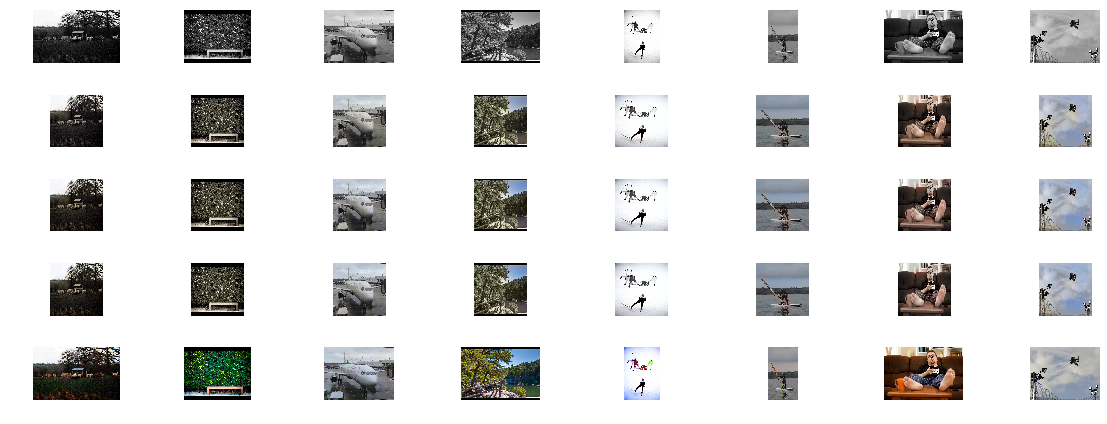

In [18]:
plt.figure(figsize=(16, 6))
for i in range(8):
    # grayscale
    plt.subplot(5, 8, i + 1)
    plt.imshow(rgb2gray(rgb_test[i]))
    plt.gray()
    plt.axis('off')
 
    # predicted
    plt.subplot(5, 8, i + 1+8)
    plt.imshow(decoded_imgs_test[i])
    plt.axis('off')
    
     # predicted-2
    plt.subplot(5, 8, i + 1+16)
    plt.imshow(decoded_imgs_test2[i])
    plt.axis('off')
    
      # predicted-3
    plt.subplot(5, 8, i + 1+24)
    plt.imshow(decoded_imgs_test3[i])
    plt.axis('off')
    
    
    # original
    plt.subplot(5, 8, i + 1+32)
    plt.imshow(rgb_test[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

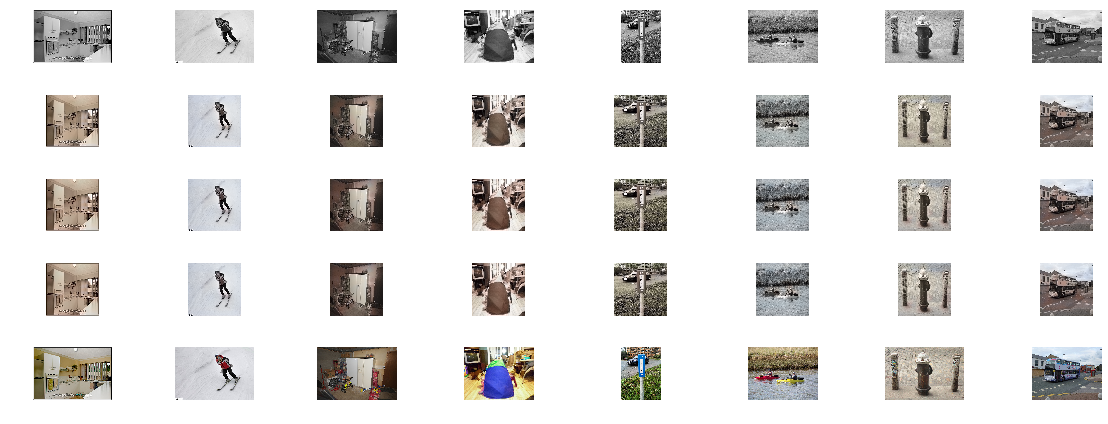

In [19]:
plt.figure(figsize=(16, 6))
for i in range(8):
    # grayscale
    plt.subplot(5, 8, i + 1)
    plt.imshow(rgb2gray(rgb_test[i+8]))
    plt.gray()
    plt.axis('off')
 
    # predicted
    plt.subplot(5, 8, i + 1+8)
    plt.imshow(decoded_imgs_test[i+8])
    plt.axis('off')
    
     # predicted-2
    plt.subplot(5, 8, i + 1+16)
    plt.imshow(decoded_imgs_test2[i+8])
    plt.axis('off')
    
      # predicted-3
    plt.subplot(5, 8, i + 1+24)
    plt.imshow(decoded_imgs_test3[i+8])
    plt.axis('off')
    
    
    # original
    plt.subplot(5, 8, i + 1+32)
    plt.imshow(rgb_test[i+8])
    plt.axis('off')

plt.tight_layout()
plt.show()

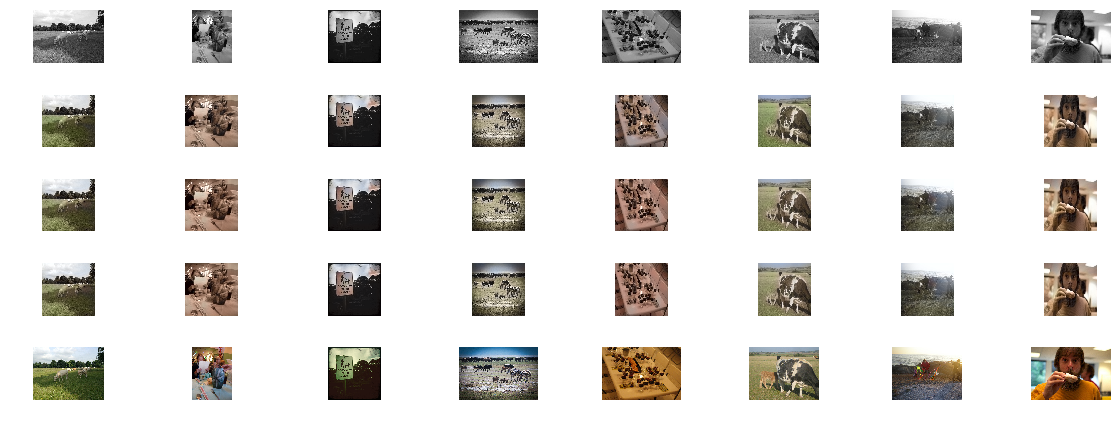

In [20]:
plt.figure(figsize=(16, 6))
for i in range(8):
    # grayscale
    plt.subplot(5, 8, i + 1)
    plt.imshow(rgb2gray(rgb_test[i+16]))
    plt.gray()
    plt.axis('off')
 
    # predicted
    plt.subplot(5, 8, i + 1+8)
    plt.imshow(decoded_imgs_test[i+16])
    plt.axis('off')
    
     # predicted-2
    plt.subplot(5, 8, i + 1+16)
    plt.imshow(decoded_imgs_test2[i+16])
    plt.axis('off')
    
      # predicted-3
    plt.subplot(5, 8, i + 1+24)
    plt.imshow(decoded_imgs_test3[i+16])
    plt.axis('off')
    
    
    # original
    plt.subplot(5, 8, i + 1+32)
    plt.imshow(rgb_test[i+16])
    plt.axis('off')

plt.tight_layout()
plt.show()

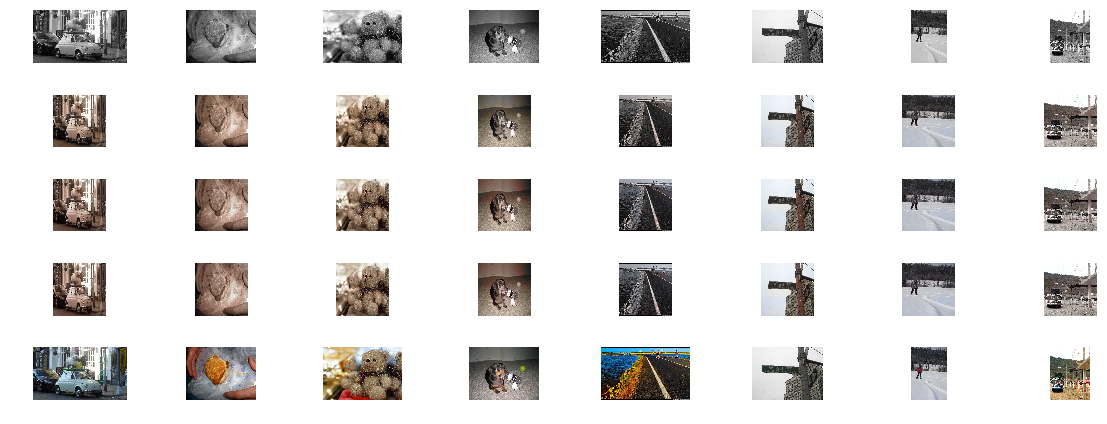

In [21]:
plt.figure(figsize=(16, 6))
for i in range(8):
    # grayscale
    plt.subplot(5, 8, i + 1)
    plt.imshow(rgb2gray(rgb_test[i+24]))
    plt.gray()
    plt.axis('off')
 
    # predicted
    plt.subplot(5, 8, i + 1+8)
    plt.imshow(decoded_imgs_test[i+24])
    plt.axis('off')
    
     # predicted-2
    plt.subplot(5, 8, i + 1+16)
    plt.imshow(decoded_imgs_test2[i+24])
    plt.axis('off')
    
      # predicted-3
    plt.subplot(5, 8, i + 1+24)
    plt.imshow(decoded_imgs_test3[i+24])
    plt.axis('off')
    
    
    # original
    plt.subplot(5, 8, i + 1+32)
    plt.imshow(rgb_test[i+24])
    plt.axis('off')

plt.tight_layout()
plt.show()

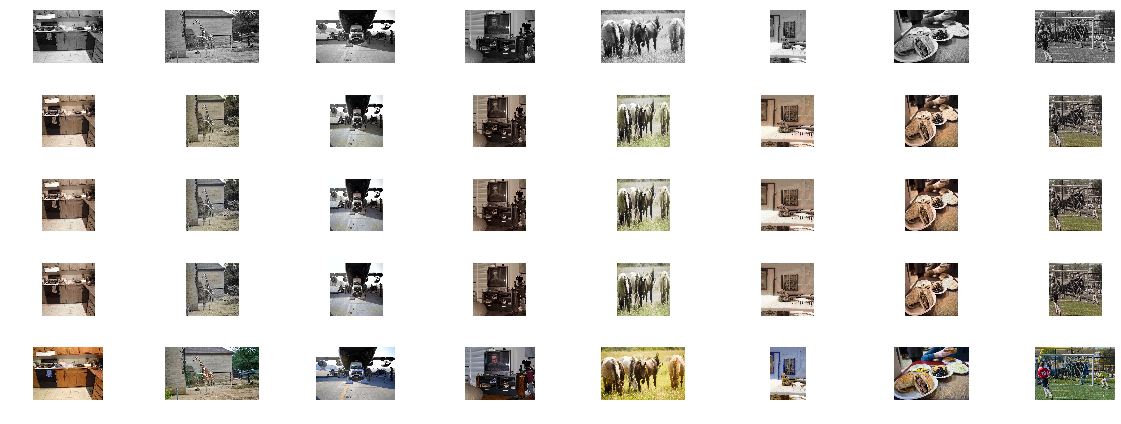

In [22]:
plt.figure(figsize=(16, 6))
for i in range(8):
    # grayscale
    plt.subplot(5, 8, i + 1)
    plt.imshow(rgb2gray(rgb_test[i+32]))
    plt.gray()
    plt.axis('off')
 
    # predicted
    plt.subplot(5, 8, i + 1+8)
    plt.imshow(decoded_imgs_test[i+32])
    plt.axis('off')
    
     # predicted-2
    plt.subplot(5, 8, i + 1+16)
    plt.imshow(decoded_imgs_test2[i+32])
    plt.axis('off')
    
      # predicted-3
    plt.subplot(5, 8, i + 1+24)
    plt.imshow(decoded_imgs_test3[i+32])
    plt.axis('off')
    
    
    # original
    plt.subplot(5, 8, i + 1+32)
    plt.imshow(rgb_test[i+32])
    plt.axis('off')

plt.tight_layout()
plt.show()

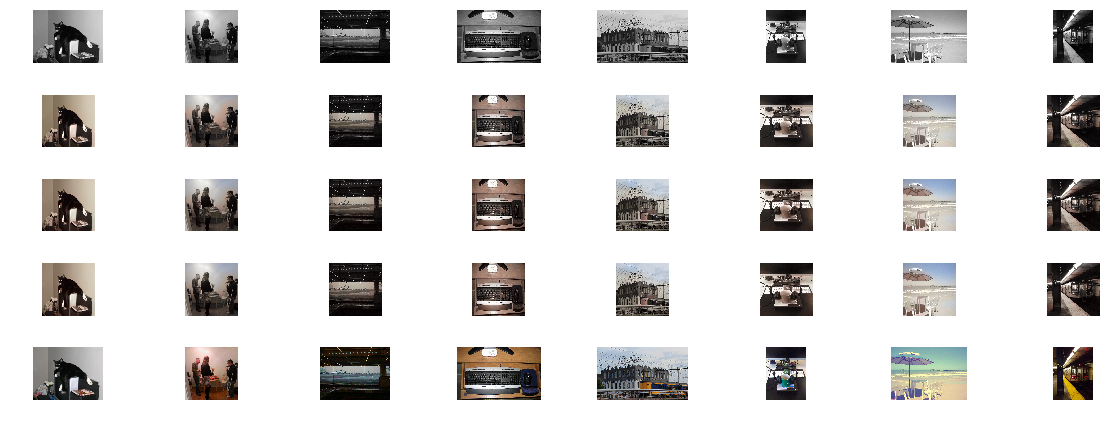

In [23]:
plt.figure(figsize=(16, 6))
for i in range(8):
    # grayscale
    plt.subplot(5, 8, i + 1)
    plt.imshow(rgb2gray(rgb_test[i+620]))
    plt.gray()
    plt.axis('off')
 
    # predicted
    plt.subplot(5, 8, i + 1+8)
    plt.imshow(decoded_imgs_test[i+620])
    plt.axis('off')
    
     # predicted-2
    plt.subplot(5, 8, i + 1+16)
    plt.imshow(decoded_imgs_test2[i+620])
    plt.axis('off')
    
      # predicted-3
    plt.subplot(5, 8, i + 1+24)
    plt.imshow(decoded_imgs_test3[i+620])
    plt.axis('off')
    
    
    # original
    plt.subplot(5, 8, i + 1+32)
    plt.imshow(rgb_test[i+620])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Best Results

In [24]:
result=[2,3,5,7,21,29,33,323,325,326,327,420,621,623,624,626]

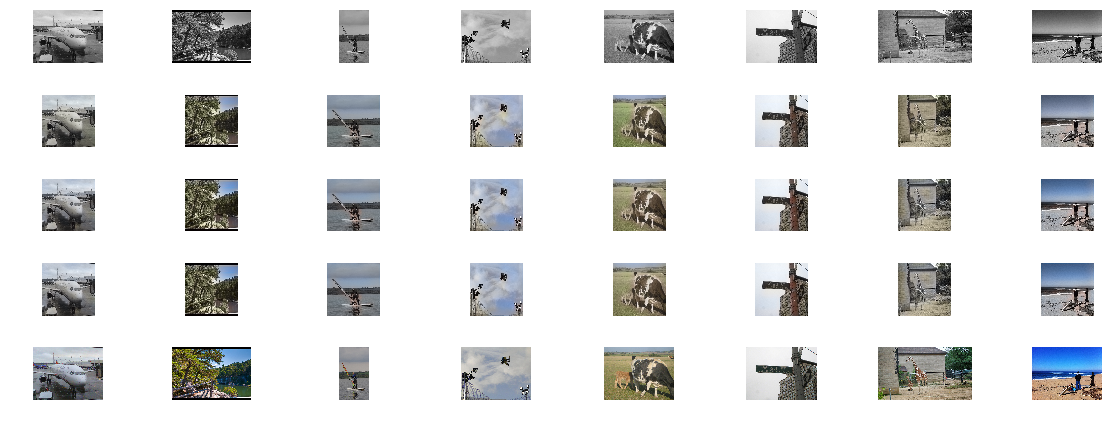

In [25]:
plt.figure(figsize=(16, 6))
for i in range(8):
    j=result[i]
    # grayscale
    plt.subplot(5, 8, i + 1)
    plt.imshow(rgb2gray(rgb_test[j]))
    plt.gray()
    plt.axis('off')
 
    # predicted
    plt.subplot(5, 8, i + 1+8)
    plt.imshow(decoded_imgs_test[j])
    plt.axis('off')
    
     # predicted-2
    plt.subplot(5, 8, i + 1+16)
    plt.imshow(decoded_imgs_test2[j])
    plt.axis('off')
    
      # predicted-3
    plt.subplot(5, 8, i + 1+24)
    plt.imshow(decoded_imgs_test3[j])
    plt.axis('off')
    
    
    # original
    plt.subplot(5, 8, i + 1+32)
    plt.imshow(rgb_test[j])
    plt.axis('off')

plt.tight_layout()
plt.show()

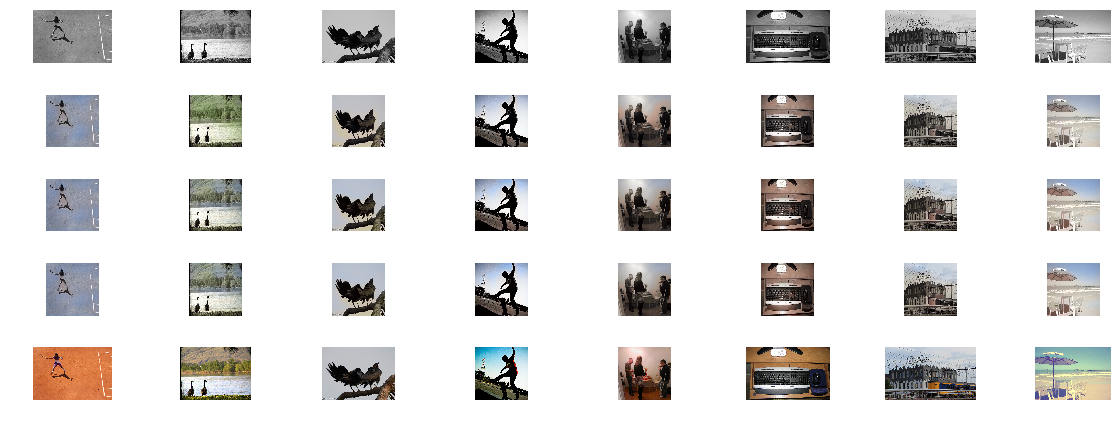

In [26]:
plt.figure(figsize=(16, 6))
for i in range(8):
    j=result[i+8]
    # grayscale
    plt.subplot(5, 8, i + 1)
    plt.imshow(rgb2gray(rgb_test[j]))
    plt.gray()
    plt.axis('off')
 
    # predicted
    plt.subplot(5, 8, i + 1+8)
    plt.imshow(decoded_imgs_test[j])
    plt.axis('off')
    
     # predicted-2
    plt.subplot(5, 8, i + 1+16)
    plt.imshow(decoded_imgs_test2[j])
    plt.axis('off')
    
      # predicted-3
    plt.subplot(5, 8, i + 1+24)
    plt.imshow(decoded_imgs_test3[j])
    plt.axis('off')
    
    
    # original
    plt.subplot(5, 8, i + 1+32)
    plt.imshow(rgb_test[j])
    plt.axis('off')

plt.tight_layout()
plt.show()

## Testing on Historical Images(First 8 are family photos and last 8 acquired from Internet)

In [28]:
#HISTORICAL IMAGES
start=0
end= 16
file_path = "/home/jupyter/Family-photos/*.jp*"
rgb_test1, lab_test1,bw_test1 =imageTransformation(file_path,start,end)


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15


In [29]:
lab_test1=np.array(lab_test1)
color_me11 = lab_test1[:,:,:,0]/50-1
color_me11 = color_me11.reshape(color_me11.shape+(1,))
bw_test1=np.array(bw_test1)
color_me_embed11 = inception_embedding(bw_test1*2 -1)

output11 = model.predict([color_me11, color_me_embed11])
output22 = model2.predict([color_me11, color_me_embed11])
output33 = model3.predict([color_me11, color_me_embed11])
output11 = output11 *128
output22 = output22 *128
output33 = output33 *128
decoded_imgs_test11 = np.zeros((len(output11),224, 224, 3))
decoded_imgs_test22 = np.zeros((len(output22),224, 224, 3))
decoded_imgs_test33 = np.zeros((len(output33),224, 224, 3))
for i in range(len(output11)):
    cur11 = np.zeros((224, 224, 3))
    cur22 = np.zeros((224, 224, 3))
    cur33 = np.zeros((224, 224, 3))
    cur11[:,:,0] = (color_me11[i][:,:,0]+1) *50
    cur22[:,:,0] = (color_me11[i][:,:,0]+1) *50
    cur33[:,:,0] = (color_me11[i][:,:,0]+1) *50
    cur11[:,:,1:] = output11[i]
    cur22[:,:,1:] = output22[i]
    cur33[:,:,1:] = output33[i]
    decoded_imgs_test11[i] = lab2rgb(cur11)
    decoded_imgs_test22[i] = lab2rgb(cur22)
    decoded_imgs_test33[i] = lab2rgb(cur33)

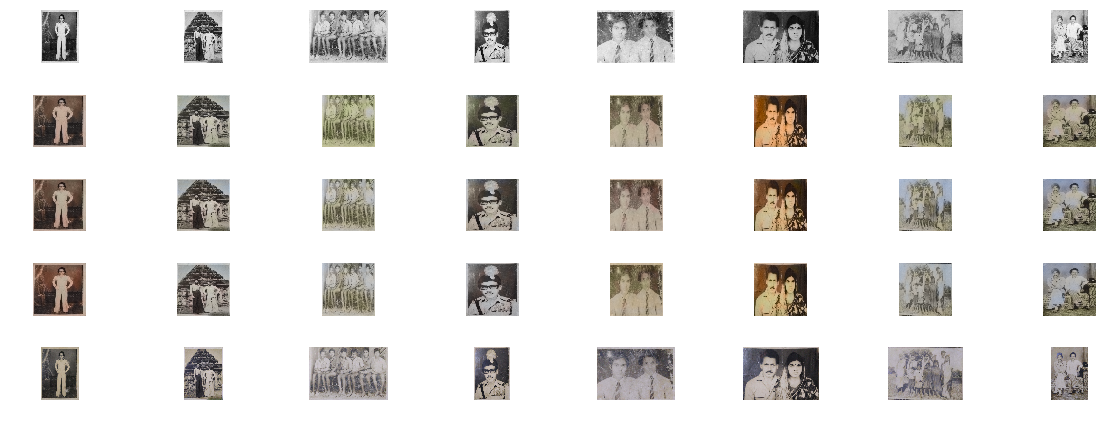

In [30]:
fig = plt.figure(figsize=(16, 6))
for i in range(8):
    # grayscale
    plt.subplot(5, 8, i + 1)
    plt.imshow(rgb2gray(rgb_test1[i]))
    plt.gray()
    plt.axis('off')
 
    # predicted
    plt.subplot(5, 8, i + 1+8)
    plt.imshow(decoded_imgs_test11[i])
    plt.axis('off')
    
     # predicted-2
    plt.subplot(5, 8, i + 1+16)
    plt.imshow(decoded_imgs_test22[i])
    plt.axis('off')
    
      # predicted-3
    plt.subplot(5, 8, i + 1+24)
    plt.imshow(decoded_imgs_test33[i])
    plt.axis('off')
    
    
    # original
    plt.subplot(5, 8, i + 1+32)
    plt.imshow(rgb_test1[i])
    plt.axis('off')

fig.savefig('family.png')
plt.tight_layout()
plt.show()

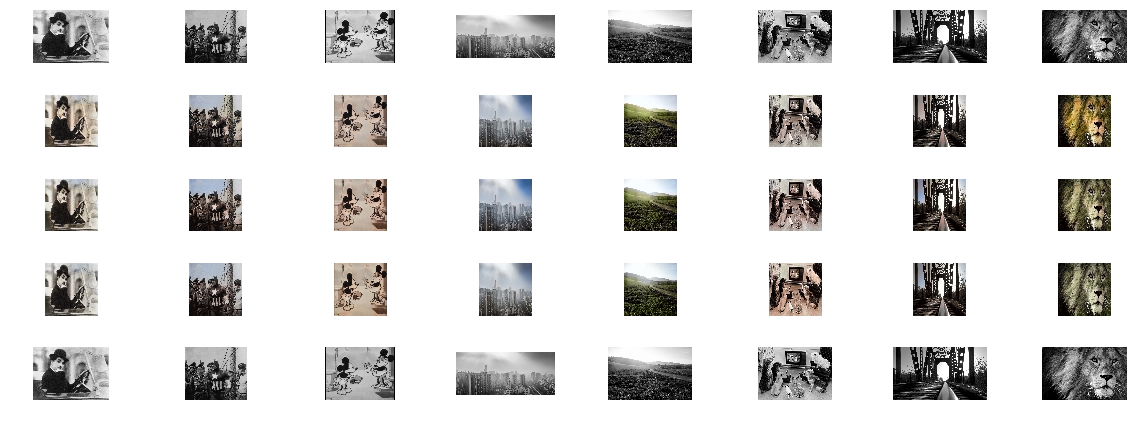

In [31]:
fig = plt.figure(figsize=(16, 6))
for i in range(8):
    # grayscale
    plt.subplot(5, 8, i + 1)
    plt.imshow(rgb2gray(rgb_test1[i+8]))
    plt.gray()
    plt.axis('off')
 
    # predicted
    plt.subplot(5, 8, i + 1+8)
    plt.imshow(decoded_imgs_test11[i+8])
    plt.axis('off')
    
     # predicted-2
    plt.subplot(5, 8, i + 1+16)
    plt.imshow(decoded_imgs_test22[i+8])
    plt.axis('off')
    
      # predicted-3
    plt.subplot(5, 8, i + 1+24)
    plt.imshow(decoded_imgs_test33[i+8])
    plt.axis('off')
    
    
    # original
    plt.subplot(5, 8, i + 1+32)
    plt.imshow(rgb_test1[i+8])
    plt.axis('off')

plt.tight_layout()
fig.savefig('fig.png')
plt.show()

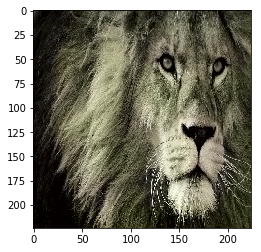

In [32]:
plt.imshow(decoded_imgs_test33[15])

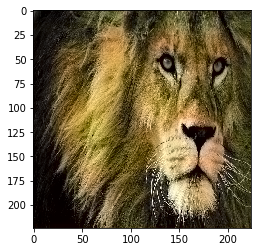

In [33]:
plt.imshow(decoded_imgs_test11[15])

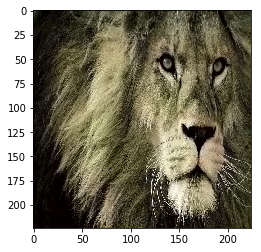

In [34]:
plt.imshow(decoded_imgs_test22[15])

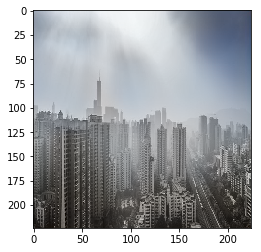

In [35]:
plt.imshow(decoded_imgs_test33[11])

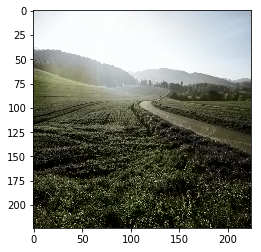

In [36]:
plt.imshow(decoded_imgs_test33[12])

In [37]:
'''
for k in range(len(decoded_imgs_test33)):
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.imshow(decoded_imgs_test33[k])
    file_name = 'image_'+str(k)+'.png'
    plt.axis('off')
    fig.savefig(file_name)


# for i in range(8):
#     # grayscale
#     plt.subplot(5, 8, i + 1)
#     plt.imshow(rgb2gray(rgb_test1[i+8]))
#     plt.gray()
#     plt.axis('off')
 
#     # predicted
#     plt.subplot(5, 8, i + 1+8)
#     plt.imshow(decoded_imgs_test11[i+8])
#     plt.axis('off')
    
#      # predicted-2
#     plt.subplot(5, 8, i + 1+16)
#     plt.imshow(decoded_imgs_test22[i+8])
#     plt.axis('off')
    
#       # predicted-3
#     plt.subplot(5, 8, i + 1+24)
#     plt.imshow(decoded_imgs_test33[i+8])
#     plt.axis('off')
    
    
#     # original
#     plt.subplot(5, 8, i + 1+32)
#     plt.imshow(rgb_test1[i+8])
#     plt.axis('off')

plt.tight_layout()
fig.savefig('fig_test.png')
plt.show()
'''

"\nfor k in range(len(decoded_imgs_test33)):\n    fig = plt.figure()\n    ax = plt.subplot(111)\n    plt.imshow(decoded_imgs_test33[k])\n    file_name = 'image_'+str(k)+'.png'\n    plt.axis('off')\n    fig.savefig(file_name)\n\n\n# for i in range(8):\n#     # grayscale\n#     plt.subplot(5, 8, i + 1)\n#     plt.imshow(rgb2gray(rgb_test1[i+8]))\n#     plt.gray()\n#     plt.axis('off')\n \n#     # predicted\n#     plt.subplot(5, 8, i + 1+8)\n#     plt.imshow(decoded_imgs_test11[i+8])\n#     plt.axis('off')\n    \n#      # predicted-2\n#     plt.subplot(5, 8, i + 1+16)\n#     plt.imshow(decoded_imgs_test22[i+8])\n#     plt.axis('off')\n    \n#       # predicted-3\n#     plt.subplot(5, 8, i + 1+24)\n#     plt.imshow(decoded_imgs_test33[i+8])\n#     plt.axis('off')\n    \n    \n#     # original\n#     plt.subplot(5, 8, i + 1+32)\n#     plt.imshow(rgb_test1[i+8])\n#     plt.axis('off')\n\nplt.tight_layout()\nfig.savefig('fig_test.png')\nplt.show()\n"